In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
sacog = pd.read_excel('../data/manipulatedData/sacog_with_new_variables.xlsx')

In [5]:
cat = ['PreparedFood', 'Groceries', 'OtherFood', 'PaperCleaning', 'Clothing','HomeOffice', 'Medication']

##### Only 21 households shopped for all categories, 86 shopped for all except ChildcareItems, 99 shopped for all except ChildcareItems and Medication

In [127]:
subset = sacog[(sacog[['style1-'+cat_ for cat_ in cat]] != 'no shopping').all(axis=1)]

In [130]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import Rank2D

In [122]:
def choose_k(X, max_k):
    inertia = []
    silhouette_score_ = []
    X = X.fillna(0)
    K = range(2, max_k)
    for k in K:
        km = KMeans(n_clusters = k, n_init = 25, max_iter = 1000, init = 'k-means++')
        km.fit_transform(X)
        inertia.append(km.inertia_)
        silhouette_score_.append(silhouette_score(X, km.labels_))
    fig, ax = plt.subplots(1,2,figsize = (16, 6))
    ax[0].plot(K, inertia, 'go-')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Inertia')
    ax[0].set_title('Elbow method for optimal K')
    ax[0].set_xticks(K)
    
    ax[1].plot(K, silhouette_score_, 'bx-')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('silhouette score')
    ax[1].set_title('Silhouette')
    ax[1].set_xticks(K)

In [123]:
def optimal_k(X, k):
    km = KMeans(n_clusters = k, n_init = 25, max_iter = 1000, init = 'k-means++', random_state=123)
    km.fit_transform(X.fillna(0))
    plt.figure(figsize = (16,5))
    plt.plot(X.columns, km.cluster_centers_.T)
    plt.xticks(rotation=45)
    display(np.unique(km.labels_, return_counts = True))
    return km

In [125]:
# Map level of online shopping dependency to ordered number: no shopping -> online only: 0 -> 5
dict_ = {
        'in-store only': 1,
        'more in-store': 2,
        'same freq': 3,
        'more online': 4,
        'online only': 5}

In [128]:
X = subset[['style1-'+ cat_ for cat_ in cat]]
X_ = pd.DataFrame()
for cat_ in cat:
    X_['style1-'+cat_] = X['style1-'+cat_].map(dict_)

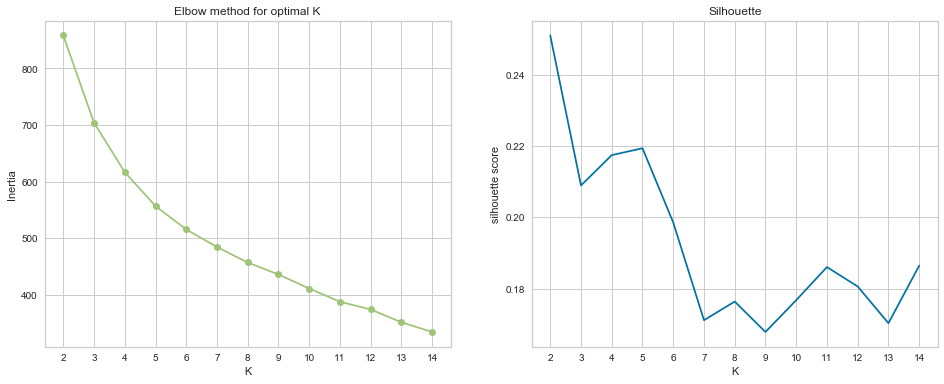

In [42]:
choose_k(X_, 15)

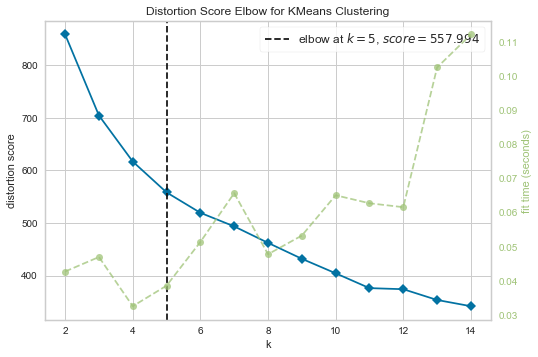

In [46]:
visualizer = KElbowVisualizer(KMeans(), k = (2, 15))
visualizer.fit(X_)
visualizer.show()

(array([0, 1, 2, 3, 4], dtype=int32), array([25, 14, 28, 10,  9]))

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,2.4,1.32,1.24,1.44,2.16,1.68,1.12,25
1,3.07143,2.07143,4.5,2.64286,2.85714,2.71429,2.42857,14
2,2.82143,1.71429,1.28571,2.17857,3.71429,4,2.89286,28
3,3.5,1.8,1.3,1.3,2.8,1.4,3.9,10
4,4.22222,3.55556,4.77778,4.44444,5,4.55556,4.44444,9


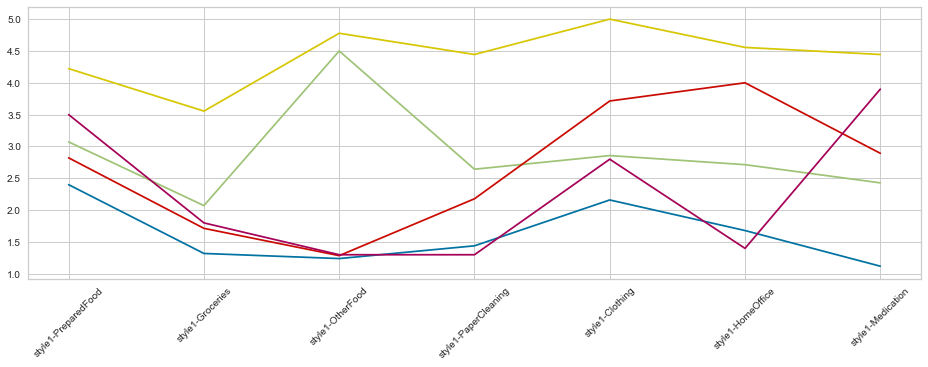

In [131]:
km = optimal_k(X_, 5)
df = pd.DataFrame(km.cluster_centers_, columns = cat)
df['group size'] = np.unique(km.labels_, return_counts = True)[1]
df.style.background_gradient(subset =cat)

In [134]:
X_[km.labels_ == 1].mean()

style1-PreparedFood     3.071429
style1-Groceries        2.071429
style1-OtherFood        4.500000
style1-PaperCleaning    2.642857
style1-Clothing         2.857143
style1-HomeOffice       2.714286
style1-Medication       2.428571
dtype: float64

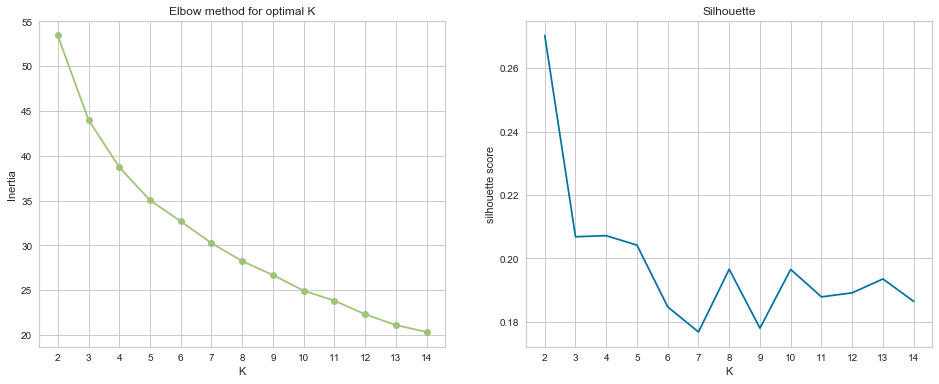

In [51]:
X = subset[['May-Portion-E'+cat_ for cat_ in cat]]
choose_k(X, 15)

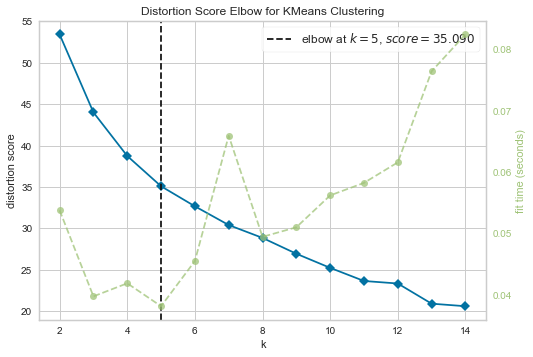

In [54]:
visualizer = KElbowVisualizer(KMeans(), k = (2, 15))
visualizer.fit(X)
visualizer.show()

In [121]:
km_p = optimal_k(X, 5)
df = pd.DataFrame(km_p.cluster_centers_, columns = cat)
df['group size'] = np.unique(km_p.labels_, return_counts = True)[1]
df.style.background_gradient()

NameError: name 'optimal_k' is not defined

In [60]:
df.style.background_gradient()

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,2.4,1.32,1.24,1.44,2.16,1.68,1.12,25
1,3.07143,2.07143,4.5,2.64286,2.85714,2.71429,2.42857,14
2,2.82143,1.71429,1.28571,2.17857,3.71429,4,2.89286,28
3,3.5,1.8,1.3,1.3,2.8,1.4,3.9,10
4,4.22222,3.55556,4.77778,4.44444,5,4.55556,4.44444,9


### KMeans with NaN? For data with NaN, only calculate the distance between the point and the centroids using available information. Assign it to the closest center. The center value is calculated by taking the average of records without NaN for each attribute, separately.

In [1]:
class kmeans_missing(object):
    def __init__(self, potential_centroids, n_clusters):
        #initialize with potential centroids
        self.n_clusters = n_clusters
        self.potential_centroids = potential_centroids
    def fit(self, data, max_iter=10, number_of_runs = 1, init = 'random'):
        
        n_clusters = self.n_clusters
        potential_centroids = self.potential_centroids
        dist_mat = np.zeros((data.shape[0], n_clusters))
        all_centroids = np.zeros((n_clusters, data.shape[1], number_of_runs))
        costs = np.zeros((number_of_runs,))
        labels = np.zeros((number_of_runs,data.shape[0]))
        
        for k in range(number_of_runs):
            
        #####################################################################################################
        ####################################### Initialization Method #######################################
            if init == 'random':
                idx = np.random.choice(range(potential_centroids.shape[0]), size = (n_clusters), replace=False)
                centroids = potential_centroids[idx]
                
            elif init == 'kmeans++':
                candidate = potential_centroids
                centroids = np.zeros((n_clusters, candidate.shape[1]))
                # initialize the first centroid randomly
                idx = np.random.choice(range(candidate.shape[0]))
                centroids[0] = candidate[idx]
                # once selected, no longer be candidate for centroids
                candidate = np.delete(candidate, idx, 0)
               
                dist_ = np.zeros((candidate.shape[0], len(centroids)-1))
                # find the other centroids
                for j in range(1, n_clusters):                   
                    # calculate the distance of candidate to each centroid
                    dist_[:,j-1] = np.sum((candidate - centroids[j-1])**2, axis = 1)
                    
                    # find the point that is the farthest from all selected centroids
                    min_dist = np.min(dist_[:,:j], axis = 1)
                    max_idx = np.argmax(min_dist)
                    
                    # update centroids and delete it from candidate
                    centroids[j] = candidate[max_idx]
                    candidate = np.delete(candidate, max_idx, 0)
                    dist_ = np.delete(dist_, max_idx, 0)
                    
         ################################################################################################### 
    
            clusters = np.zeros((data.shape[0],))
            old_clusters = np.zeros(data.shape[0])

            
            for i in range(max_iter):
                # Step 1: calculate distance to centroids
                for j in range(n_clusters):
                    # for records with nan, the distance will be calculated using only features with valid value.
                    dist_mat[:,j] = np.nansum((centroids[j]-data)**2, axis = 1)
                    
                # Step 2: Assign to clusters
                clusters = np.argmin(dist_mat, axis = 1)
                
                # Step 3: Update clusters centroids
                for j in range(n_clusters):
                    centroids[j] = np.nanmean(data[clusters == j], axis = 0)
                
                # When # of identified clusters < n_clusters, reset centroids
                if np.isnan(centroids).any():
                    centorids = potential_centroids[idx]
                    
                if all(np.equal(clusters, old_clusters)):
                    break
                    
                if i == max_iter - 1:
                    print('no convergence before maximun iteration')
                    # Avoid the case that put all records in one cluster
                    centroids = potential_centroids[idx]
                    for j in range(n_clusters):
                        dist_mat[:,j] = np.nansum((data - centroids[j])**2, axis = 1)
                else:
                    clusters, old_clusters = old_clusters, clusters # seems not necessary to assign old_clusters to clusters
            
            all_centroids[:,:,k] = centroids
            costs[k] = np.mean(np.min(dist_mat, axis = 1))
            labels[k] = np.argmin(dist_mat, axis = 1)
            
        self.costs = costs
        self.costs = np.min(costs)
        self.best_model = np.argmin(costs)
        self.centroids = all_centroids[:,:, self.best_model]
        self.all_centroids = all_centroids
        self.labels = labels[self.best_model]

In [ ]:
import numpy as np
class kmeans_missing(object):
    def __init__(self,potential_centroids,n_clusters):
        #initialize with potential centroids
        self.n_clusters=n_clusters
        self.potential_centroids=potential_centroids
    def fit(self,data,max_iter=10,number_of_runs=1):
        n_clusters=self.n_clusters
        potential_centroids=self.potential_centroids

        dist_mat=np.zeros((data.shape[0],n_clusters))
        all_centroids=np.zeros((n_clusters,data.shape[1],number_of_runs))

        costs=np.zeros((number_of_runs,))
        for k in range(number_of_runs):
            idx=np.random.choice(range(potential_centroids.shape[0]), size=(n_clusters), replace=False)
            centroids=potential_centroids[idx]
            
            clusters=np.zeros(data.shape[0])
            old_clusters=np.zeros(data.shape[0])
            for i in range(max_iter):
                #Calc dist to centroids
                for j in range(n_clusters):
                    dist_mat[:,j]=np.nansum((data-centroids[j])**2,axis=1)
                #Assign to clusters
                clusters=np.argmin(dist_mat,axis=1)
                #Update clusters
                for j in range(n_clusters):
                    centroids[j]=np.nanmean(data[clusters==j],axis=0)
                if all(np.equal(clusters,old_clusters)):
                    break # Break when to change in clusters
                if i==max_iter-1:
                    print('no convergence before maximal iterations are reached')
                else:
                    clusters,old_clusters = old_clusters,clusters

            all_centroids[:,:,k]=centroids
            costs[k]=np.mean(np.min(dist_mat,axis=1))
        self.costs=costs
        self.cost=np.min(costs)
        self.best_model=np.argmin(costs)
        self.centroids=all_centroids[:,:,self.best_model]
        self.all_centroids=all_centroids
    def predict(self,data):
        dist_mat=np.zeros((data.shape[0],self.n_clusters))
        for j in range(self.n_clusters):
            dist_mat[:,j]=np.nansum((data-self.centroids[j])**2,axis=1)
        prediction=np.argmin(dist_mat,axis=1)
        cost=np.min(dist_mat,axis=1)
        return prediction,cost

In [136]:
subset = sacog[~sacog[['May-Portion-E'+cat_ for cat_ in cat]].isna().any(axis = 1)]
subset = subset[['May-Portion-E'+cat_ for cat_ in cat]]

In [137]:
X = sacog[['May-Portion-E'+cat_ for cat_ in cat]]

In [107]:
km.fit(X.to_numpy(), 10000, 10000, init = 'kmeans++')

In [2]:
km = kmeans_missing(subset.to_numpy(), 5)

NameError: name 'subset' is not defined

In [178]:
km.fit(X.to_numpy(), 10000, 12)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


no convergence before maximun iteration


In [179]:
X[km.labels ==0].mean()

May-Portion-EPreparedFood     0.575621
May-Portion-EGroceries        0.120919
May-Portion-EOtherFood        0.096429
May-Portion-EPaperCleaning    0.399148
May-Portion-EClothing         0.693077
May-Portion-EHomeOffice       0.828452
May-Portion-EMedication       0.153704
dtype: float64

In [180]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.665277,0.673969,0.746377,0.852707,0.941402,0.882778,0.826918,52
1,0.436039,0.309697,0.783186,0.358333,0.43558,0.394286,0.280435,76
2,0.541114,0.119306,0.106202,0.264683,0.695901,0.82418,0.412018,110
3,0.305483,0.0324694,0.0118519,0.0289157,0.165861,0.123129,0.1,41
4,0.131657,0.0622243,0.0609195,0.0806967,0.742921,0.210784,0.782083,48


In [120]:
X[km.labels==0].mean()

May-Portion-EPreparedFood     0.126696
May-Portion-EGroceries        0.086400
May-Portion-EOtherFood        0.085859
May-Portion-EPaperCleaning    0.294529
May-Portion-EClothing         0.855243
May-Portion-EHomeOffice       0.681609
May-Portion-EMedication       0.315714
dtype: float64

In [105]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.499823,0.124291,0.0809524,0.337984,0.640293,0.723853,0.161006,39
1,0.522581,0.296287,0.760614,0.300538,0.397272,0.345714,0.422751,93
2,0.671168,0.656168,0.746377,0.811141,0.941402,0.893434,0.833841,82
3,0.160424,0.0693377,0.0645833,0.0843905,0.79904,0.458559,0.773551,50
4,0.257527,0.0302631,0.0130081,0.0109705,0.143743,0.0789116,0.132353,63


In [103]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.499823,0.124291,0.0809524,0.337984,0.640293,0.723853,0.161006,115
1,0.522581,0.296287,0.760614,0.300538,0.397272,0.345714,0.422751,35
2,0.671168,0.656168,0.746377,0.811141,0.941402,0.893434,0.833841,53
3,0.160424,0.0693377,0.0645833,0.0843905,0.79904,0.458559,0.773551,47
4,0.257527,0.0302631,0.0130081,0.0109705,0.143743,0.0789116,0.132353,77


In [101]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.499823,0.124291,0.0809524,0.337984,0.640293,0.723853,0.161006,56
1,0.522581,0.296287,0.760614,0.300538,0.397272,0.345714,0.422751,77
2,0.671168,0.656168,0.746377,0.811141,0.941402,0.893434,0.833841,67
3,0.160424,0.0693377,0.0645833,0.0843905,0.79904,0.458559,0.773551,58
4,0.257527,0.0302631,0.0130081,0.0109705,0.143743,0.0789116,0.132353,69


In [99]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.499823,0.124291,0.0809524,0.337984,0.640293,0.723853,0.161006,45
1,0.522581,0.296287,0.760614,0.300538,0.397272,0.345714,0.422751,77
2,0.671168,0.656168,0.746377,0.811141,0.941402,0.893434,0.833841,43
3,0.160424,0.0693377,0.0645833,0.0843905,0.79904,0.458559,0.773551,76
4,0.257527,0.0302631,0.0130081,0.0109705,0.143743,0.0789116,0.132353,86


In [232]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.283298,0.0394394,0.0199768,0.0199134,0.106061,0.0507246,0.148718,71
1,0.451658,0.108371,0.06,0.306294,0.652004,0.659506,0.122424,53
2,0.534973,0.290457,0.759167,0.297066,0.411765,0.402857,0.430688,86
3,0.665462,0.640018,0.715278,0.817436,0.935963,0.893434,0.83254,48
4,0.160424,0.0693377,0.0645833,0.0843905,0.79904,0.458559,0.773551,69


In [229]:
df = pd.DataFrame(km.centroids, columns=cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset = cat)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.280147,0.036996,0.0130081,0.0135965,0.102564,0.0518519,0.163978,67
1,0.170127,0.0739701,0.0607843,0.0849196,0.785135,0.468376,0.765625,78
2,0.449114,0.100559,0.0648649,0.313662,0.660562,0.659993,0.0921212,45
3,0.665462,0.640018,0.715278,0.817436,0.935963,0.893434,0.83254,74
4,0.538559,0.291237,0.74482,0.301207,0.410096,0.391667,0.420672,63


In [169]:
df = pd.DataFrame(km.centroids, columns = cat)
df['group size'] = np.unique(km.labels, return_counts=True)[1]
df.style.background_gradient(subset=cat)


#km.centroids

#np.unique(km.labels, return_counts = True)

,PreparedFood,Groceries,OtherFood,PaperCleaning,Clothing,HomeOffice,Medication,group size
0,0.480415,0.0935265,0.0829268,0.287751,0.649404,0.667613,0.118129,45
1,0.305806,0.0381807,0.0267996,0.0247967,0.123188,0.047619,0.18408,85
2,0.166128,0.0622027,0.0645833,0.0858974,0.793379,0.446491,0.782005,68
3,0.468048,0.362644,0.791724,0.343236,0.398529,0.436667,0.395614,83
4,0.671168,0.639234,0.715278,0.828382,0.935963,0.893434,0.83254,46


In [155]:
X = sacog[['May-Portion-E'+cat_ for cat_ in cat]]

In [211]:
K = range(2, 15)
cost = []
for k in K:
    km = kmeans_missing(subset.to_numpy(), k)
    km.fit(X.to_numpy(), 10000, 1000)
    cost.append(km.costs)



/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration


no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration


no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration


no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration
no convergence before maximun iteration


AttributeError: Unknown property figsize

<Figure size 576x396 with 0 Axes>

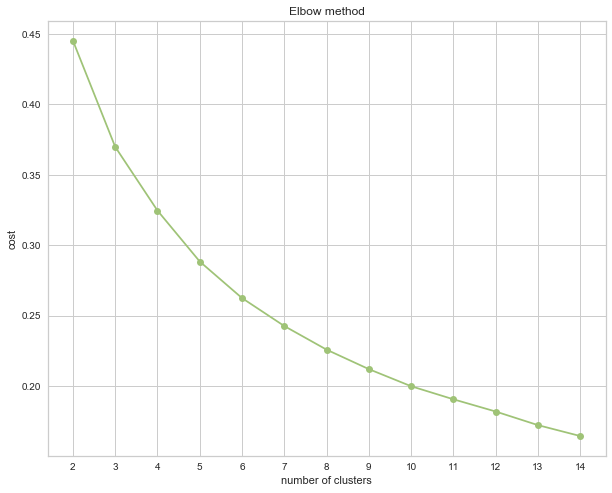

In [220]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(K, cost, 'go-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('cost')
ax.set_title('Elbow method')
ax.set_xticks(K)